# XGBOOST

## Objetivo de esta lección

Aprender el que es posiblemente el algoritmo que actualmente es considerado como el rey de los algoritmos de ML supervisado: Xgboost.

Además aprenderemos sobre la categoría general de Boosting y los modelos Gradient Boosting Machines.

## Contexto y antecedentes

En la lección anterior de Random Forest ya vimos que había 2 grandes estrategias para mejorar los resultados de los modelos basados en árboles.

La primera era bagging, que ya la explicamos y cuya mejor implementación actual son los Random Forest.

Y la otra era Boosting, que simplemente la nombramos.

A diferencia de Bagging que funciona desarrollando muchos modelos en paralelo y luego combinándolos, Boosting funciona también haciendo muchos modelos pero donde cada uno está destinado a mejorar la predicción en los casos en los que el anterior no consiguió tener buena predicción, intentando capturar los patrones no capturados en los errores hasta que el error parezca aleatorio.

La predicción final se realiza integrando todas las predicciones de cada uno de los árboles individuales que conforman el modelo final.

Es por eso que estos modelos suelen ser más precisos, ya que trabajan reduciendo el sesgo (frente a los de bagging que reducían la varianza), pero pueden tener más riesgo de sobre ajustar.

La primera implementación famosa de este concepto fue con un algoritmo que se llama Adaboost.

Después llegó Gradient Boosting Machines y alguna variación como Stochastic Gradient Boosting.

GBM mejoraba mucho la capacidad predictiva, pero tenía el problema de que era muy pesado y tardaba mucho en entrenarse.

A grandes rasgos el concepto clave es el de "optimización del gradiente", por lo que todos estos algoritmos tienen un parámetro llamado "learning rate" que ajusta el nivel de corrección del gradiente en cada iteración. En la práctica se suele situar entre  0.001 y 0.01.

Stochastic Gradient Boosting introducía una mejora traída de bagging, el muestreo aleatorio de observaciones de entrenamiento. Es decir, en lugar de volver a usar todos los datos en cada iteración SGB usa sólo una muestra aleatoria.

En la opción que se llama mini-batch esa muestra es de varios casos. En la opción pura de Stochastic Gradient Boosting llega a ser incluso de un solo caso por iteración.

Pero como decíamos GBM es lento, y el motivo es porque para hacer los cortes de las variables necesita iterar sobre todos los valores observados de cada variable predictora.

Así que la siguiente generación solucionó este problema con la estrategia que se llama binning, que básicamente consiste en discretizar y buscar los cortes por tramos, lo cual agiliza mucho el proceso.

En resumen, que este es un campo en contínuo desarrollo y mejora.

Por ello, aunque el algoritmo de boosting que ahora mismo implementa Sklearn es GBM con GradientBoostingClassifier() y GradientBoostingRegressor() ambos del módulo ensemble, nosotros vamos a aprender los que son hoy considerados como los mejores algoritmos: XGBoost (en esta lección) y LightGBM (en la siguiente).

Para XGBoost vamos a necesitar un paquete externo a Sklearn pero que tiene una interfaz para usarlos con la misma metodología que ya conocemos.

XGBoost viene de eXtreme Gradient Boosting.

## FICHA DEL ALGORITMO

### Ámbito de aplicación

XGGoost se puede aplicar tanto en ámbitos de clasificación como de regresión.

XGBoost tiene una clase diferente para cada caso:

* Para clasificación: XGBClassifier()
* Para regresión: XGBRegressor()

Al igual que RF no tiene una salida fácilmente explicable, así que el ámbito de aplicación ideal es cuando se requiere una alta precisión sin una gran capacidad de interpretación.

También ha mejorado mucho la velocidad de entrenamiento gracias al uso de binning y a que está nativamente diseñado para trabajar en paralelo y aprovechar todos los cores del equipo, así que es un algoritmo indicado cuando tenemos muchos datos.

Incluso acepta GPUs.

### Pros

* Muy rápido
* Muy buena capacidad predictiva
* Cubre clasificación y regresión
* No necesita preselección previa de variables
* Métrica incorporada de importancia de las variables
* Incorpora regularización con los parámetors reg-alpha (L1) y reg-lambda (L2)
* No necesita casi preparación de datos
* Captura muy bien relaciones no lineales
* No tiene hipótesis a cumplir
* Puede optimizar para diferentes métricas, tanto en clasificación como en regresión

### Contras

* No tiene una interpretación ni una explicación directa
* Necesita encoding para los predictores categóricos

### Necesidad de preprocesamiento

No sensible a outliers.

No hace falta escalado.

No hace falta preselección de variables.

Gestiona automáticamente los nulos (no hay que preprocesarlos). Lo que hace en el entrenamiento es que, en las variables en las que haya nulos crea dos versiones de esa rama. En una versión asigna los nulos a un lado y en la otra version al otro lado. Después compara y se queda con la asingación que minimiza el error.

Necesita enconding de las variables categóricas.

### Supuestos e hipótesis

No tiene.

### Sobre ajuste

Boosting puede tender al sobre ajuste.

Pero XGBoost tiene varios parámetros para aplicar diferentes estrategias para que no suceda:

* parámetros para controlar el learning rate
* parámetros para controlar la regularización
* parámetros para controlar la complejidad de cada árbol

### Grado de interpretación

Bajo.

La salida son cientos de árboles que no podemos ponernos a interpretar ni a visualizar individualmente.

Pero sí tiene una métrica de importancia de las variables que por lo menos nos ayuda a entender los principales predictores para lo que estemos analizando.

### Instalación e importación

Como decíamos XGboost es un paquete externo a Sklearn.

Lo instalamos así:

conda install -c conda-forge xgboost

Y lo cargamos así:

In [2]:
#Clasificación
from xgboost import XGBClassifier

#Regresión
from xgboost import XGBRegressor

### CLASIFICACIÓN

#### Principales parámetros

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* learning_rate: cuanto más alto mayor velocidad de aprendizaje. Por defecto 0.1 
* n_estimators: el número de árboles a crear. Por defecto 100. Recomendado entre 100 y 1000, pero cuidado porque puede sobre ajustar
* reg_alpha: regularización en L1
* reg_lambda: regularización en L2
* max_depth: el número de niveles máximo del árbol
* scale_pos_weight: ratio de negativos / positivos para balancear
* n_jobs: número de cores a usar
* gamma: es un parámetro de poda. por defecto es cero que significa no poda, pero si hay altas diferencias entre los  resultados de train y test usar un valor alto como 10

Además hay 3 parámetros especiales porque no se ponen en la instanciación, si no en el fit:

* early_stopping_rounds: es una especie de hiperparametrización interna para ajustar n_estimators. Significa que si pasa del número de iteraciones especificado aquí sin tener mejoras ya no seguirá incrementando n_estimators. Para usarlo hay que pasarle en fit un conjunto de test con eval_set. Un buen número es ponerlo a 5.
* eval_set: es una lista con los predictores de test y la target de test para que ajuste el parámetro anterior. eval_set=[(test_x, test_y)]
* eval_metric: la métrica de evaluación sobre el conjunto de test. Recomiendo poner 'auc'

#### Parametrización recomendada

Hasta que no cojas experiencia propia puede intimidar el tener que tomar decisiones sobre qué valor dar a los parámetros.

A partir de la experiencia de competiciones en Kaggle se recomiendan que los valores de los parámetros estén entre los siguientes, que puedes usar como punto de partida.

In [3]:
learning_rate = [0.01,0.015,0.025,0.05,0.1]
gamma = [0.05,0.1,0.3,0.5,0.7,0.9,1,10]
max_depth = [3,5,7,9,12,15,17,25]
reg_alpha = [0,0.1,0.5,1]
reg_lambda = [0.01,0.1,1]

#### Principales atributos de resultado

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* feature_importances_: para ver la importancia de cada variable

#### Principales métodos

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* fit(): para entrenar
* predict_proba(): para generar el scoring
* get_params(): para extraer los parámetros del modelo entrenado

### REGRESIÓN

#### Principales parámetros

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* learning_rate: cuanto más alto mayor velocidad de aprendizaje. Por defecto 0.1 
* n_estimators: el número de árboles a crear. Por defecto 100. Recomendado entre 100 y 1000, pero cuidado porque puede sobre ajustar
* reg_alpha: regularización en L1
* reg_lambda: regularización en L2
* max_depth: el número de niveles máximo del árbol
* n_jobs: número de cores a usar
* gamma: es un parámetro de poda. por defecto es cero que significa no poda, pero si hay altas diferencias entre los  resultados de train y test usar un valor alto como 10

Además hay 3 parámetros especiales porque no se ponen en la instanciación, si no en el fit:

* early_stopping_rounds: si pasa del número de iteraciones especificado aquí sin tener mejoras ya no seguirá haciendo más iteraciones. Para usarlo hay que pasarle en fit un conjunto de test con eval_set. Un buen número es ponerlo a 5.
* eval_set: es una lista con los predictores de test y la target de test para que ajuste el parámetro anterior. eval_set=[(test_x, test_x)]
* eval_metric: la métrica de evaluación sobre el conjunto de test. Recomiendo poner 'rmse' o 'mae'

#### Parametrización recomendada

Hasta que no cojas experiencia propia puede intimidar el tener que tomar decisiones sobre qué valor dar a los parámetros.

A partir de la experiencia de competiciones en Kaggle se recomiendan que los valores de los parámetros estén entre los siguientes, que puedes usar como punto de partida.

In [4]:
learning_rate = [0.01,0.015,0.025,0.05,0.1]
gamma = [0.05,0.1,0.3,0.5,0.7,0.9,1,10]
max_depth = [3,5,7,9,12,15,17,25]
reg_alpha = [0,0.1,0.5,1]
reg_lambda = [0.01,0.1,1]

#### Principales atributos de resultado

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* feature_importances_: para ver la importancia de cada variable

#### Principales métodos

https://xgboost.readthedocs.io/en/latest/python/python_api.html

* fit(): para entrenar
* predict(): para generar el scoring
* get_params(): para extraer los parámetros del modelo entrenado

## EJEMPLO

### Opciones y paquetes

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Automcompletar rápido
%config IPCompleter.greedy=True

### Importación de datos

Vamos a usar el dataset sintético de target binaria.

In [6]:
#Cargamos el dataset sintetico_binaria.csv que está en 00_DATASETS
df = pd.read_csv('sintetico_binaria.csv')
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,target
0,-0.3,-1.6,-0.3,-1.5,2.6,1.5,-2.2,-0.4,1.9,0
1,-1.0,0.0,-0.0,-1.5,0.5,0.6,-0.7,0.2,0.3,1
2,1.7,-1.3,-0.4,-2.2,-2.0,-0.9,-2.6,1.0,2.4,1
3,-1.9,-1.7,1.3,-0.6,-0.9,-0.6,-0.4,2.6,-1.2,0
4,1.0,-0.5,2.3,-0.5,2.1,3.6,-2.4,1.1,1.4,1
...,...,...,...,...,...,...,...,...,...,...
995,0.1,-0.7,0.5,-0.8,0.1,0.3,-0.6,1.2,-0.4,0
996,-0.6,1.6,2.7,-1.3,-0.1,2.7,0.3,-1.9,2.5,0
997,1.0,-1.7,1.1,-0.7,-2.3,-1.1,-1.4,3.8,-1.1,0
998,-0.8,0.5,3.3,-0.4,-1.8,2.8,-3.6,6.3,-1.8,0


### Modelo

#### Separar predictoras y target

In [7]:
x = df.drop(columns = 'target')
y = df['target']

#### Separar train y test

In [8]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3)

#### Entrenar el modelo

In [9]:
from xgboost import XGBClassifier

# Instanciar el clasificador y configurar los parámetros
xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', early_stopping_rounds=5)

# Entrenar
xgb.fit(train_x, train_y, eval_set=[(test_x, test_y)])


[0]	validation_0-auc:0.70892
[1]	validation_0-auc:0.72913
[2]	validation_0-auc:0.73209
[3]	validation_0-auc:0.73900
[4]	validation_0-auc:0.74342
[5]	validation_0-auc:0.75164
[6]	validation_0-auc:0.75317
[7]	validation_0-auc:0.76184
[8]	validation_0-auc:0.75484
[9]	validation_0-auc:0.76130
[10]	validation_0-auc:0.76510
[11]	validation_0-auc:0.76142
[12]	validation_0-auc:0.76028
[13]	validation_0-auc:0.76034
[14]	validation_0-auc:0.76453
[15]	validation_0-auc:0.76848
[16]	validation_0-auc:0.76985
[17]	validation_0-auc:0.77123
[18]	validation_0-auc:0.77242
[19]	validation_0-auc:0.77428
[20]	validation_0-auc:0.77751
[21]	validation_0-auc:0.77816
[22]	validation_0-auc:0.77822
[23]	validation_0-auc:0.77774
[24]	validation_0-auc:0.77840
[25]	validation_0-auc:0.77679
[26]	validation_0-auc:0.77493
[27]	validation_0-auc:0.77727
[28]	validation_0-auc:0.77631
[29]	validation_0-auc:0.77386


/home/vscode/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:25:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Predecir sobre test

In [10]:
pred = xgb.predict_proba(test_x)[:, 1]
pred[:10]

array([0.872179  , 0.2581501 , 0.9874594 , 0.00807258, 0.00474588,
       0.84677815, 0.9046085 , 0.02208617, 0.24806958, 0.61395556],
      dtype=float32)

#### Evaluar sobre test

In [11]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_y,pred)

np.float64(0.7784022961014111)

#### Revisión de los parámetros de entrenamiento

In [12]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 5,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

#### Análisis de la importancia de las variables

XGBoost calcula la importancia de las variables como la ganancia media en todos los nodos en los que se ha usado la variable.

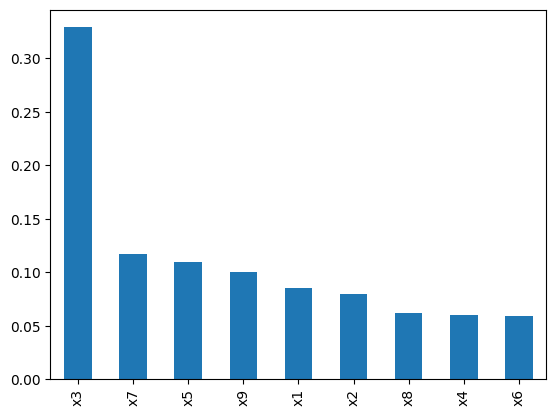

In [13]:
pd.Series(xgb.feature_importances_,index = test_x.columns).sort_values(ascending = False).plot(kind = 'bar');

O un dataframe

In [14]:
importancia = pd.DataFrame({'variable': test_x.columns, 'importancia': xgb.feature_importances_})
importancia.sort_values(by = 'importancia', ascending = False)

,variable,importancia
2,x3,0.3
6,x7,0.1
4,x5,0.1
8,x9,0.1
0,x1,0.1
1,x2,0.1
7,x8,0.1
3,x4,0.1
5,x6,0.1
